In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def read_serie_CC_data(var, obs_data_path, projected_data_folder, model_names, scenario, target_date):
     
    projected_serie = []
    delta_factors   = []
    
    obs_data = pd.read_csv(obs_data_path)
    stations = obs_data.columns[1:]
    
    data_cc_path = os.path.join(projected_data_folder,var)
    os.chdir(data_cc_path)
    
    for station in stations: 
        data_CC  = pd.DataFrame(index= pd.to_datetime(obs_data.iloc[:,0]))
        data_CC[station] = np.array(obs_data[station])
        
        delta_CC = pd.DataFrame(index=np.arange(1,13,1))

        for model in model_names:
    
            filename = f'{var}_{model}_{scenario}_{target_date[0]}_{target_date[1]}'

            data_model_serie  = pd.read_csv(f'{filename}.csv')
            delta_model_serie = pd.read_csv(f'{filename}_delta.csv')

            data_CC[model]  = np.array(data_model_serie[station])
            delta_CC[model] = np.array(delta_model_serie[station])
        
        projected_serie.append(data_CC)
        delta_factors.append(delta_CC)
           
    dict_series_CC = {stations[i]: projected_serie[i] for i in range(len(stations))}
    dict_delta_CC  = {stations[i]: delta_factors[i] for i in range(len(stations))}
    
    return dict_series_CC, dict_delta_CC

In [3]:
def output_folder_directory(var, outputh_folder_path):
    # Create output folte if it does not exist
    output_path = os.path.join(outputh_folder_path, var)
    isExist = os.path.exists(output_path)

    if isExist == False:
        os.makedirs(output_path) 
    
    os.chdir(output_path)
    return output_path

In [4]:
def plot_serie_CC_data(dict_series_CC, dict_delta_CC,  var, scenario, target_date, ouput_folder):
    
    stations = list(dict_series_CC.keys())
    
    for station in stations:
        
        data_CC_serie = dict_series_CC[station]
        data_CC_serie_avgmon = data_CC_serie.groupby(data_CC_serie.index.month).mean()
        
        nro_models=data_CC_serie_avgmon.shape[1]
        
        data_CC_serie_avgmon = data_CC_serie_avgmon.reindex([8,9,10,11,12,1,2,3,4,5,6,7])
        data_CC_serie_avgmon['months'] = ['Aug','Sep', 'Oct', 'Nov', 'Dic','Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul']
        data_CC_serie_avgmon = data_CC_serie_avgmon.set_index('months')
        
        fig1, axs = plt.subplots(1,1, figsize=(8,4))
        
        colors = ['C0','C1','C3','C2']
        
        for i,model in enumerate(data_CC_serie_avgmon.columns[1:]):
            
            axs.plot(data_CC_serie_avgmon.index, data_CC_serie_avgmon[model], 
                     color=colors[i], marker='s', linestyle=":",label=model)
            
        
        data_CC_serie_avgmon['Mediana'] = np.array(data_CC_serie_avgmon.iloc[:,1:nro_models].median(axis=1))
        
        
        axs.plot(data_CC_serie_avgmon.index, data_CC_serie_avgmon['Mediana'], 
                 color=colors[i+1], marker='s',linestyle=":", label=f'Mediana Ensamble')                      
            
        axs.plot(data_CC_serie_avgmon.index, data_CC_serie_avgmon.iloc[:,0], 
                 color='black', marker='o', label=f'Obs.\n{station.replace("_"," ")}')    
        
        if var == 'pr':
            axs.set_ylabel('$Precipitación/mes (mm)$', fontsize=10)      
            axs.set_ylim([0,240])
        elif var == 'tasmax':
            axs.set_ylabel('$Temperatura (°C)$', fontsize=10)      
            axs.set_ylim([20,40])            
        elif var == 'tasmin':
            axs.set_ylabel('$Temperatura (°C)$', fontsize=10)      
            axs.set_ylim([10,30]) 
            
            
        axs.legend(loc='upper right')
        
        dict_delta_CC[station]['median'] = np.array(dict_delta_CC[station].iloc[:,:nro_models].median(axis=1))
        dict_delta_CC[station]['min'] = np.array(dict_delta_CC[station].iloc[:,:nro_models].min(axis=1))
        dict_delta_CC[station]['max'] = np.array(dict_delta_CC[station].iloc[:,:nro_models].max(axis=1))
        
        ouput_folder = output_folder_directory(var, ouput_folder)
        os.chdir(ouput_folder)
        
        dict_delta_CC[station].round(3).to_csv(f'{station}_{var}_{scenario}_{target_date[0]}_{target_date[1]}_delta.csv')
        
        data_CC_serie_avgmon.round(3).to_csv(f'{station}_{var}_{scenario}_{target_date[0]}_{target_date[1]}.csv')
        
        fig1.savefig(f'{station}_{var}_{scenario}_{target_date[0]}_{target_date[1]}', bbox_inches='tight', dpi=300)     
        

In [5]:
def read_plot_projected_series(var, obs_data_path, projected_data_folder, 
                               model_names, scenario, target_date, ouput_folder):
    print('Processing...')
    print(f'{var}_{scenario}_{target_date[0]}_{target_date[1]}')
    
    dict_series_CC, dict_delta_CC = read_serie_CC_data(var, obs_data_path, projected_data_folder, model_names, scenario, target_date)
    plot_serie_CC_data(dict_series_CC, dict_delta_CC,  var, scenario, target_date, ouput_folder)
    print(f'Done!')
    
    

Processing...
pr_ssp585_2036_2065
Done!
Processing...
tasmax_ssp585_2036_2065
Done!
Processing...
tasmin_ssp585_2036_2065
Done!


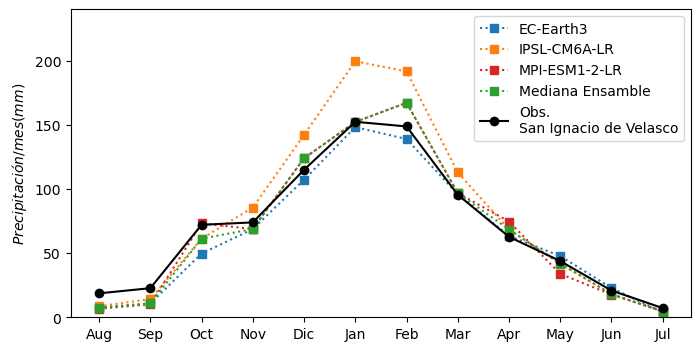

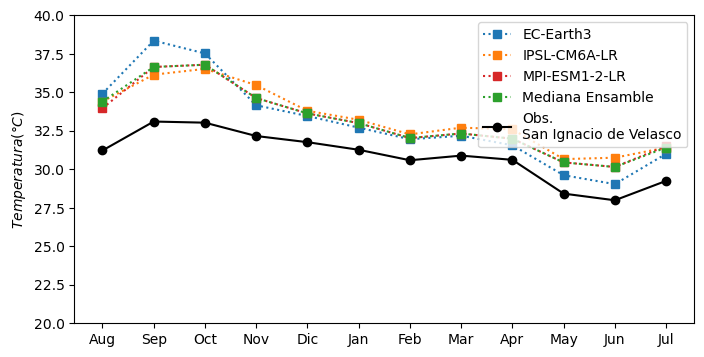

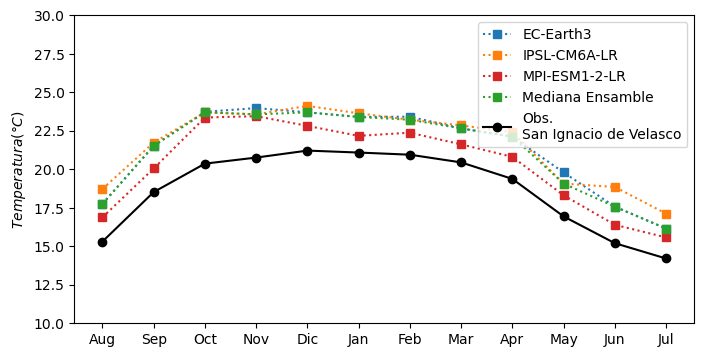

In [7]:
projected_data_folder = r"D:\PROYECTOS\03_Represa_Sapoco\05_CC\cc_delta_data"
model_names = ['EC-Earth3','IPSL-CM6A-LR','MPI-ESM1-2-LR']
scenario = 'ssp585'
target_date = [2036, 2065]
ouput_folder = r"D:\PROYECTOS\03_Represa_Sapoco\05_CC\02_cc_table_graphics"


var = 'pr'
obs_data_path         = rf"D:\PROYECTOS\03_Represa_Sapoco\05_CC\observed_data\{var}.csv"
read_plot_projected_series(var, obs_data_path, projected_data_folder, model_names, scenario, target_date, ouput_folder)

var = 'tasmax'
obs_data_path         = rf"D:\PROYECTOS\03_Represa_Sapoco\05_CC\observed_data\{var}.csv"
read_plot_projected_series(var, obs_data_path, projected_data_folder, model_names, scenario, target_date, ouput_folder)

var = 'tasmin'
obs_data_path         = rf"D:\PROYECTOS\03_Represa_Sapoco\05_CC\observed_data\{var}.csv"
read_plot_projected_series(var, obs_data_path, projected_data_folder, model_names, scenario, target_date, ouput_folder)

Processing...
tasmin_ssp585_2036_2065
Done!


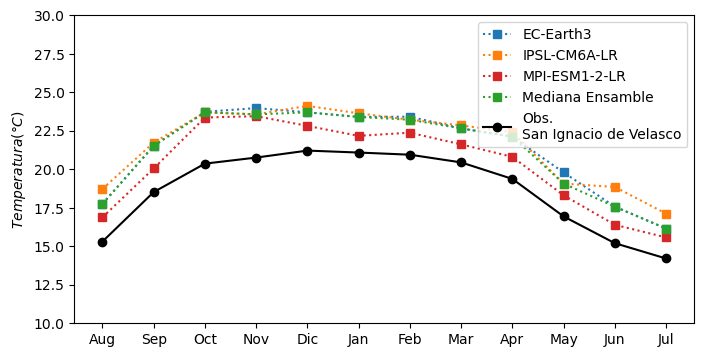

In [39]:
var = 'tasmin'
projected_data_folder = r"D:\PROYECTOS\03_Represa_Sapoco\05_CC\cc_delta_data"
obs_data_path         = rf"D:\PROYECTOS\03_Represa_Sapoco\05_CC\observed_data\{var}.csv"
projected_data_folder = r"D:\PROYECTOS\03_Represa_Sapoco\05_CC\cc_delta_data"

model_names = ['EC-Earth3','IPSL-CM6A-LR','MPI-ESM1-2-LR']
scenario = 'ssp585'
target_date = [2036, 2065]
ouput_folder = r"D:\PROYECTOS\03_Represa_Sapoco\05_CC\cc_table_graphics"

read_plot_projected_series(var, obs_data_path, projected_data_folder, model_names, scenario, target_date, ouput_folder)